# Loading and Saving Your Data

Spark supports a wide range of input and output sources, partly because it builds on the ecosystem available for Hadoop.

Spark can access data through the `InputFormat` and `OutputFormat` interfaces used by Hadoop MapReduce, which are available for many common file formats and storage systems (e.g., S3, HDFS, Cassandra, HBase, etc.).

We will cover three common sets of data sources:
    
* File formats and filesystems:
    * For data stored in a local or distributed filesystem, such as NFS, HDFS, or Amazon S3, Spark can access a variety of file formats including text, JSON, SequenceFiles, and protocol buffers. 

* Structured data sources through Spark SQL
    * The Spark SQL module provides a nicer and often more efficient API for **structured data sources**, including JSON and Apache Hive. 

* Databases and key/value stores
    * Built-in and third-party libraries for connecting to Cassandra, HBase, Elasticsearch, and JDBC databases.

Most of the methods here to be available in all of Spark’s languages, but some libraries are still Java and Scala only. 

### File Formats

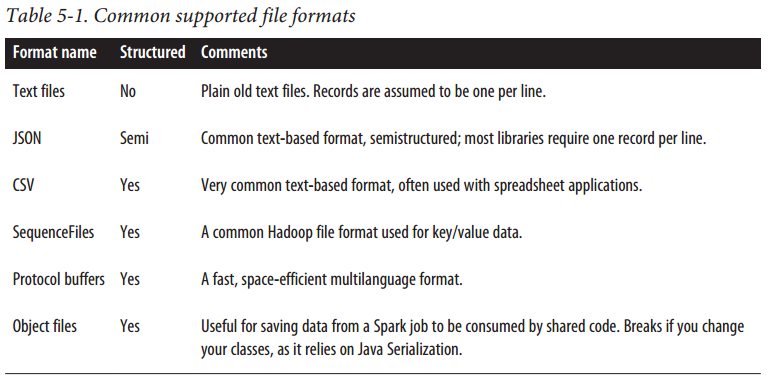

In addition to the output mechanisms supported directly in Spark, we can use both Hadoop’s new and old file APIs for keyed (or paired) data. 

We can use these only with key/value data, because the *Hadoop interfaces require key/value data*, even though some formats ignore the key. In cases where the format ignores the key, it is common to use a `dummy key` (such as `null`).

### Text Files

When we load a **single text** file as an RDD: 

Each input line becomes an element in the RDD. 

We can also **load multiple** whole text files at the same time into a **pair RDD**, with the key being the name and the value being the contents of each file.

#### Loading text files

Call the `textFile()` function on our `SparkContext` with the path to the file

Control the number of partitions with `minPartitions`

In [1]:
# Loading a text file in Python
input = sc.textFile("file:///home/holden/repos/spark/README.md")

//Loading a text file in Scala
val input = sc.textFile("file:///home/holden/repos/spark/README.md")

//Loading a text file in Java
JavaRDD<String> input = sc.textFile("file:///home/holden/repos/spark/README.md")

SyntaxError: invalid syntax (<ipython-input-1-860ac8870055>, line 4)

**Multipart inputs** in the form of a directory containing all of the parts can be handled
in two ways: 

* Use the same `textFile` method and pass it a directory and it will **load all of the parts into our RDD** (A basic RDD). 

Sometimes it’s important to know which file which piece of input came from (such as time data with the key in the file) or we need to process an entire file at a time. 


* If our files are small enough, we can use the `SparkContext.wholeTextFiles()` method and get back a **pair RDD** where *key is the name of the input file*. `wholeTextFiles()` can be very useful when **each file represents a certain time period’s data**. 

If we had files representing sales data from different periods, we could easily compute the average for each period.

In [2]:
// Average value per file in Scala

val input = sc.wholeTextFiles("file://home/holden/salesFiles")
val result = input.mapValues{y =>
val nums = y.split(" ").map(x => x.toDouble)
nums.sum / nums.size.toDouble
}

SyntaxError: invalid syntax (<ipython-input-2-10e5e840f03d>, line 1)

Note

Spark supports reading all the files in a given directory and doing wildcard expansion on the input (e.g., `part-*.txt`). This is useful since large datasets are often spread across multiple files, especially if other files (like success markers) may be in the same directory.

### Saving text files

The method `saveAsTextFile()` takes a path and will output the contents of the RDD to that
file.

The path is treated as a directory and Spark will **output multiple files underneath that directory**. 
This allows Spark to write the **output from multiple nodes**. With this method **we don’t get to control which files end up with which segments of our data**, but there are other output formats that do allow this.

In [3]:
result.saveAsTextFile(outputFile)

NameError: name 'result' is not defined

#### JSON

The simplest way to load JSON data is by 

* loading the data as a text file 
* and then mapping over the values with a JSON parser. 

Likewise, we can use our preferred JSON serialization library to write out the values to strings, which we can then write out. In Java and Scala we can also work with JSON data using a **custom Hadoop format**. We can also load JSON data with Spark SQL.

#### Loading JSON

Loading the data as a text file and then parsing the JSON data is an approach that we
can use *in all of the supported languages*. 

This works assuming that you have *one JSON record per row*; 

If you have **multiline JSON files**: 

You will instead have to load the whole file and then parse each file. 

If constructing a JSON parser is expensive in your language, you can use `mapPartitions()` to reuse the parser; see “Working on a Per-Partition Basis” on page 107 for details.

There are a wide variety of JSON libraries available for the three languages we are looking at, but for simplicity’s sake we are considering only one library per language.

In Python we will use the *built-in library* (Example 5-6)

in Java and Scala we will use `Jackson`. 

If you spend a lot of time in the parsing stage, look at other JSON libraries for Scala or for Java.

In [4]:
# Loading unstructured JSON in Python
import json
data = input.map(lambda x: json.loads(x))

AttributeError: 'function' object has no attribute 'map'

In Scala and Java, it is common to *load records into a class representing their schemas*. At this stage, we may also want to skip invalid records. We show an example of loading records as instances of a `Person` class.

In [6]:
// Loading JSON in Scala
import com.fasterxml.jackson.module.scala.DefaultScalaModule
import com.fasterxml.jackson.module.scala.experimental.ScalaObjectMapper
import com.fasterxml.jackson.databind.ObjectMapper
import com.fasterxml.jackson.databind.DeserializationFeature
...
case class Person(name: String, lovesPandas: Boolean) // Must be a top-level class
...
// Parse it into a specific case class. We use flatMap to handle errors
// by returning an empty list (None) if we encounter an issue and a
// list with one element if everything is ok (Some(_)).
val result = input.flatMap(record => {
try {
Some(mapper.readValue(record, classOf[Person]))
} catch {
case e: Exception => None
}})


//Example 5-8. Loading JSON in Java
class ParseJson implements FlatMapFunction<Iterator<String>, Person> {
public Iterable<Person> call(Iterator<String> lines) throws Exception {
ArrayList<Person> people = new ArrayList<Person>();
ObjectMapper mapper = new ObjectMapper();
while (lines.hasNext()) {
String line = lines.next();
try {
people.add(mapper.readValue(line, Person.class));
} catch (Exception e) {
// skip records on failure
}
}
return people;
}
}
JavaRDD<String> input = sc.textFile("file.json");
JavaRDD<Person> result = input.mapPartitions(new ParseJson());

SyntaxError: invalid syntax (<ipython-input-6-baf9c5d3fce2>, line 1)

NOte

Handling incorrectly formatted records can be a big problem, especially with semistructured data like JSON. With small datasets it can be acceptable to stop the world (i.e., fail the program) on malformed input, but often with large datasets malformed input is simply a part of life. If you do choose to skip incorrectly formatted data, you may wish to look at using `accumulators` to keep track of the number of errors.

##### Saving JSON

We can use the same libraries we used to convert our RDD of strings into parsed JSON data and instead take our RDD of structured data and convert it into an RDD of strings, which we can then write out using Spark’s text file API.

In [7]:
# Saving JSON in Python
(data.filter(lambda x: x['lovesPandas']).map(lambda x: json.dumps(x)).saveAsTextFile(outputFile))


// Saving JSON in Scala
result.filter(p => P.lovesPandas).map(mapper.writeValueAsString(_))
.saveAsTextFile(outputFile)


// Saving JSON in Java
class WriteJson implements FlatMapFunction<Iterator<Person>, String> {
public Iterable<String> call(Iterator<Person> people) throws Exception {
ArrayList<String> text = new ArrayList<String>();
ObjectMapper mapper = new ObjectMapper();
while (people.hasNext()) {
Person person = people.next();
text.add(mapper.writeValueAsString(person));
}
return text;
}
}
JavaRDD<Person> result = input.mapPartitions(new ParseJson()).filter(
new LikesPandas());
JavaRDD<String> formatted = result.mapPartitions(new WriteJson());
formatted.saveAsTextFile(outfile);

SyntaxError: invalid syntax (<ipython-input-7-230889cf45b0>, line 5)

### Comma-Separated Values and Tab-Separated Values

Records are often stored *one per line*, but this is not always the case as records can sometimes span lines. 

CSV and TSV files can sometimes be inconsistent, most frequently with respect to handling newlines, escaping, and rendering non-ASCII characters, or noninteger numbers. 

CSVs cannot handle nested field types natively, so we have to unpack and pack to specific fields manually.

Unlike with JSON fields, each record doesn’t have field names associated with it;
instead we get back row numbers. It is common practice in single CSV files to make
the first row’s column values the names of each field.

##### Loading CSV

Loading CSV/TSV data is similar to loading JSON data in that we can **first load it as text** and **then process it**. The lack of standardization of format leads to different versions of the same library sometimes handling input in different ways.

As with JSON, there are many different CSV libraries, but we will use only one for each language. Once again, in Python we use the included `csv` library. In both Scala and Java we use `opencsv`.

There is also a Hadoop InputFormat, CSVInputFormat, that we can use to load CSV data in Scala and Java, although it does not support records containing newlines.

If your CSV data happens to **not contain newlines in any of the fields**, you can load your data with `textFile()` and parse it:

In [9]:
# Loading CSV with textFile() in Python
import csv
import StringIO
...
def loadRecord(line):
    """Parse a CSV line"""
    input = StringIO.StringIO(line)
    reader = csv.DictReader(input, fieldnames=["name", "favouriteAnimal"])
return reader.next()
input = sc.textFile(inputFile).map(loadRecord)

// Loading CSV with textFile() in Scala
import Java.io.StringReader
import au.com.bytecode.opencsv.CSVReader
...
val input = sc.textFile(inputFile)
val result = input.map{ line =>
val reader = new CSVReader(new StringReader(line));
reader.readNext();
}

// Loading CSV with textFile() in Java
import au.com.bytecode.opencsv.CSVReader;
import Java.io.StringReader;
...
public static class ParseLine implements Function<String, String[]> {
public String[] call(String line) throws Exception {
CSVReader reader = new CSVReader(new StringReader(line));
return reader.readNext();
}
}
JavaRDD<String> csvFile1 = sc.textFile(inputFile);
JavaPairRDD<String[]> csvData = csvFile1.map(new ParseLine());

SyntaxError: invalid syntax (<ipython-input-9-f90fe73722e7>, line 12)

If there are *embedded newlines in fields*, we will need to load each **file in full and parse the entire segment**. This is unfortunate because if each file is large it can introduce bottlenecks in loading and parsing.



In [10]:
# Loading CSV in full in Python
def loadRecords(fileNameContents):
    """Load all the records in a given file"""
    input = StringIO.StringIO(fileNameContents[1])
    reader = csv.DictReader(input, fieldnames=["name", "favoriteAnimal"])
    return reader
fullFileData = sc.wholeTextFiles(inputFile).flatMap(loadRecords)

// Loading CSV in full in Scala
case class Person(name: String, favoriteAnimal: String)
val input = sc.wholeTextFiles(inputFile)
val result = input.flatMap{ case (_, txt) =>
val reader = new CSVReader(new StringReader(txt));
reader.readAll().map(x => Person(x(0), x(1)))
}

// Example 5-17. Loading CSV in full in Java
public static class ParseLine
implements FlatMapFunction<Tuple2<String, String>, String[]> {
public Iterable<String[]> call(Tuple2<String, String> file) throws Exception {
CSVReader reader = new CSVReader(new StringReader(file._2()));
return reader.readAll();
}
}
JavaPairRDD<String, String> csvData = sc.wholeTextFiles(inputFile);
JavaRDD<String[]> keyedRDD = csvData.flatMap(new ParseLine());

SyntaxError: invalid syntax (<ipython-input-10-18007fa597f9>, line 9)

If there are only a few input files, and you need to use the whole `File()` method, you may want to `repartition` your input to allow Spark to effectively parallelize your future operations.

##### Saving CSV

Since in CSV we don’t output the field name with each record, to have a consistent output we need to create a mapping. One of the easy ways to do this is to just write a function that converts the fields to given positions in an array. In Python, if we are outputting dictionaries the CSV writer can do this for us based on the order in which we provide the fieldnames when constructing the writer.

The CSV libraries we are using output to files/writers so we can use `StringWriter/
StringIO` to allow us to put the result in our RDD,

In [11]:
# Writing CSV in Python
def writeRecords(records):
    """Write out CSV lines"""
    output = StringIO.StringIO()
    writer = csv.DictWriter(output, fieldnames=["name", "favoriteAnimal"])
    for record in records:
        writer.writerow(record)
    return [output.getvalue()]

pandaLovers.mapPartitions(writeRecords).saveAsTextFile(outputFile)


// Writing CSV in Scala
pandaLovers.map(person => List(person.name, person.favoriteAnimal).toArray)
.mapPartitions{people =>
val stringWriter = new StringWriter();

val csvWriter = new CSVWriter(stringWriter);
csvWriter.writeAll(people.toList)
Iterator(stringWriter.toString)
}.saveAsTextFile(outFile)

SyntaxError: invalid syntax (<ipython-input-11-a41962104735>, line 13)

The preceding examples work only provided that **we know all of the fields that we will be outputting**. However, if some of the field names are determined at runtime from user input, we need to take a different approach. The simplest approach is *going over all of our data and extracting the distinct keys and then taking another pass for output*